In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import scipy
import scipy.fft as fft
import astropy.constants as const
import astropy.units as u
from astropy.io import fits
from astropy.io import ascii
from astropy.convolution import Gaussian2DKernel
from astropy.cosmology import LambdaCDM
from photutils.segmentation import detect_threshold
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources
from photutils.segmentation import SourceCatalog
from scipy.interpolate import interp2d
from scipy.optimize import curve_fit
from math import pi
import math
import csv

In [2]:
#-----Loading data
cat = ascii.read('bullet_435.cat')

#-----Morphological Properties
xcen = cat['X_IMAGE'].data     # max(xcen): 7011.474, min(xcen): 311.515
ycen = cat['Y_IMAGE'].data     # max(ycen): 4638.641, min(ycen): 311.515
phi = cat['THETA_IMAGE'].data

xmin = cat['XMIN_IMAGE'].data
xmax = cat['XMAX_IMAGE'].data  
ymin = cat['YMIN_IMAGE'].data  # rms = fits.open('bullet_f435w_RMS.fits'), rms[0].shape : (5100, 7013)
ymax = cat['YMAX_IMAGE'].data  # min(xmin): 264, max(xmax): 7013, min(ymin):311, max(ymax):4643
                                       
a = cat['A_IMAGE'].data        # Profile RMS along major axis 라는데 확실히 맞는지는 모르겠다.
b = cat['B_IMAGE'].data 

#-----Make image               ##### !!I have a question!! ##### 이미지는 catalog로부터 못 만드는 것 같은데 그럼 이미지는 어떻게 만드나? drz_sci랑 RMS 모두 정상적으로 안나오는데..?
image = np.zeros((5100,7013))

#-----gamma, gamma1, gamma2
r = (a-b) / (a+b)
r1 = r * np.cos(2*phi)
r2 = r * np.sin(2*phi)
#r_cos_phi = r * np.cos(phi)
#r_sin_phi = r * np.sin(phi)

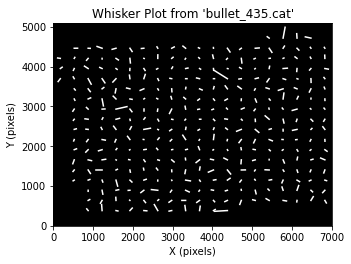

In [8]:
#-----Whisker Plot

r1_mean_list = np.array([])
r2_mean_list = np.array([])

length_r = np.array([])

loc_start = np.empty((0,2))
loc_end = np.empty((0,2))

dim2_array_r1 = np.zeros((20,20))   # 여기서 바로 mass map 그리는데 필요한 2차원 상의 gamma값 그려보려고 추가함.
dim2_array_r2 = np.zeros((20,20))   

for i in range(20):
    for j in range(20):
        ind = np.where( (255*i<ycen) & (ycen<255*(i+1)) & (350*j<xcen) & (xcen<350*(j+1)) )         # 20by20 각 셀의 indexing
        # 현재 cat의 number는 4474개

        r1_mean = 1e3*np.mean(r1[ind])                                                              # 각 셀에서의 gamma1과 gamma2의 평균(대표로 쓸 값)
        r2_mean = 1e3*np.mean(r2[ind])
        r1_mean_list = np.append(r1_mean_list, r1_mean)
        r2_mean_list = np.append(r2_mean_list, r2_mean)

        center = np.array([350*j+350/2, 255*i+255/2], dtype='float64').reshape(1,2)                 # 20by20의 각 셀의 중심 좌표
        loc_start = np.append(loc_start, center, axis=0)
        
        stick_end = np.array([center[0][0]+r1_mean, center[0][1]+r2_mean]).reshape(1,2)
        loc_end = np.append(loc_end, stick_end, axis=0)                                             # 20by20의 각 셀에 해당하는 whisker plot의 끝 점 좌표

        dim2_array_r1[i][j] += r1_mean/1e3                           # 여기서 바로 mass map 그리는데 필요한 2차원 상의 gamma값 그려보려고 추가함.
        dim2_array_r2[i][j] += r2_mean/1e3


ind = np.where(np.isnan(dim2_array_r1))
dim2_array_r1[ind]=0

ind2 = np.where(np.isnan(dim2_array_r2))
dim2_array_r2[ind]=0

background = np.zeros((5100,7013))                                   # 행이 y뜻함

fig = plt.figure(figsize=(5,5))
plt.imshow(background, cmap='gray', origin = 'lower')
plt.plot([loc_start[:,0],loc_end[:,0]], [loc_start[:,1],loc_end[:,1]], color='w')
plt.title("Whisker Plot from 'bullet_435.cat'")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.show()


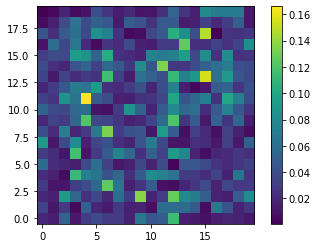

In [37]:
# 20by20으로 kappa map 그린 버전


#-----mass distribution map(=kappa map)

R1_fft = fft.fft2(dim2_array_r1)

R2_fft = fft.fft2(dim2_array_r2)

k1 = fft.fftfreq(R1_fft.shape[1], d=350)
k2 = fft.fftfreq(R2_fft.shape[0], d=255)


#####k = ( k1**2 + k2**2 )**(1/2) #이것도 놓쳤네.. meshgrid 써야만한다. 라인바이라인으로 점검 꼼꼼히 하면서 넘어가자.
K1, K2 = np.meshgrid(k1,k2)

#####K = ( K1**2 + K2**2 )**(1/2) #Kappa_fft 구할때 작은 수 곱해주는 것이 아니라 여기서 작은 수 '더해주는 것'이다.
K = ( K1**2 + K2**2 )**(1/2) + 1e-7

# print(r1_fft.shape[0]==len(x)) ### 주의! array의 인덱스는 행과 열 순서이므로 x,y 순이 아니다. y,x 순이다!
# print(r1_fft.shape[1]==len(y)) ### 주의! array의 인덱스는 행과 열 순서이므로 x,y 순이 아니다. y,x 순이다!

Kappa_fft = K**(-2) * ( (K1**2-K2**2)*R1_fft + 2*K1*K2*R2_fft )
Kappa = fft.ifft2(Kappa_fft)
Kappa_power = np.abs(Kappa)

fig = plt.imshow(Kappa_power, origin='lower')
plt.colorbar(fig)
plt.show()



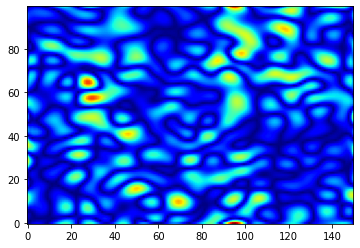

In [29]:
#-----mass distribution map(=kapp map)


R1_intep = interp2d(np.linspace(0,7012,20), np.linspace(0,5099,20), dim2_array_r1, kind='cubic')
R2_intep = interp2d(np.linspace(0,7012,20), np.linspace(0,5099,20), dim2_array_r2, kind='cubic')

# R1_intep = interp2d(loc_start[:,0], loc_start[:,1], r1_mean_list, kind='cubic')
# R2_intep = interp2d(loc_start[:,0], loc_start[:,1], r2_mean_list, kind='cubic')

x = np.linspace(0,7012,150)
y = np.linspace(0,5099,100)

R1_new = R1_intep(x,y)                  ### 이제부터 2차원 배열은 대문자로 
R2_new = R2_intep(x,y)

R1_fft = fft.fft2(R1_new)
R2_fft = fft.fft2(R2_new)

k1 = fft.fftfreq(R1_fft.shape[1], d=1)
k2 = fft.fftfreq(R2_fft.shape[0], d=1)

#####k = ( k1**2 + k2**2 )**(1/2) #이것도 놓쳤네.. meshgrid 써야만한다. 라인바이라인으로 점검 꼼꼼히 하면서 넘어가자.
K1, K2 = np.meshgrid(k1,k2)

#####K = ( K1**2 + K2**2 )**(1/2) #Kappa_fft 구할때 작은 수 곱해주는 것이 아니라 여기서 작은 수 '더해주는 것'이다.
K = ( K1**2 + K2**2 )**(1/2) + 1e-5

# print(r1_fft.shape[0]==len(x)) ### 주의! array의 인덱스는 행과 열 순서이므로 x,y 순이 아니다. y,x 순이다!
# print(r1_fft.shape[1]==len(y)) ### 주의! array의 인덱스는 행과 열 순서이므로 x,y 순이 아니다. y,x 순이다!

Kappa_fft = K**(-2) * ( (K1**2-K2**2)*R1_fft + 2*K1*K2*R2_fft )

Kappa = fft.ifft2(Kappa_fft)

Kappa_power = np.abs(Kappa)

plt.imshow(Kappa_power, cmap='jet', origin='lower')
plt.title("")
plt.show()

